In [5]:
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import geopandas as gpd
import rioxarray as rio
import xarray as xr
import numpy as np

from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import mapping

from src import geoaxes

plt.style.use('dark_background')

In [6]:
cm_data_ = [[1.0, 1.0, 1.0],
           [0.8823529411764706, 1.0, 1.0],
           [0.7058823529411765, 0.9411764705882353, 0.9803921568627451],
           [0.5882352941176471, 0.8235294117647058, 0.9803921568627451],
           [0.1568627450980392, 0.5098039215686274, 0.9411764705882353],
           [0.0784313725490196, 0.39215686274509803, 0.8235294117647058],
           [0.403921568627451, 0.996078431372549, 0.5215686274509804],
           [0.09411764705882353, 0.8431372549019608, 0.023529411764705882],
           [0.11764705882352941, 0.7058823529411765, 0.11764705882352941],
           [1.0, 0.9098039215686274, 0.47058823529411764],
           [1.0, 0.7529411764705882, 0.23529411764705882],
           [1.0, 0.3764705882352941, 0.0],
           [0.8823529411764706, 0.0784313725490196, 0.0],
           [0.984313725490196, 0.3686274509803922, 0.4196078431372549],
           [0.6666666666666666, 0.6666666666666666, 0.6666666666666666]]

ons_cmap = LinearSegmentedColormap.from_list('ons', cm_data_)
ons_cmap_r = LinearSegmentedColormap.from_list('ons', cm_data_[::-1])

In [7]:
def mask_data(ds: xr.Dataset, mask: str) -> xr.Dataset:
    """
    Mask data within a geographical extension directly from a shapefile.

    Parameters
    ----------
        ds : ``xarray.Dataset``
            Two-dimensional (2D) array database to which to apply mask.
            
        mask : str, path object or file-like object
            Shapefile to mask dataset.

    Returns
    -------
        ``xarray.Dataset``
            Masked data.
    """
    # GeoDataFrame from a shapefile 
    shape = gpd.read_file(mask)
    # Set the spatial dimensions of the dataset
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    # Write the CRS to the dataset in a CF compliant manner
    ds.rio.write_crs("epsg:4326", inplace=True)
    # Clip using a GeoDataFrame
    return ds.rio.clip(shape.geometry.apply(mapping), 
                       shape.crs, drop=False)

In [8]:
# Lendo o dataset
ds_precip = xr.open_dataset(r"C:\Users\jonec\Projects\mapas_augusto\data\precip_79_22.nc")
#Convertendo de metro para mm
ds_precip = ds_precip * 1000


""" ---------------- Climatolotgia--------------"""
clim_period = ['1991-01-01', '2020-12-01']
ds_clim = ds_precip.sel(time=slice(clim_period[0], clim_period[1]))
ds_clim = ds_clim.groupby('time.month').mean()

""" ---------------- Observado------------------"""

obs_period = ['2022-01-01', '2022-12-01']
ds_obs = ds_precip.sel(time=slice(obs_period[0], obs_period[1]))
ds_obs = ds_obs.groupby('time.month').mean()

""" ---------------- Anomalia------------------"""
# ds_anom_mm = ds_clim - ds_obs #(anomalia em mm)
ds_anom = (ds_obs/ds_clim-1)*100

""" ---------------- Shapes--------------------"""
shapefile = r'C:\Users\jonec\Projects\mapas_augusto\data\UFEBRASIL.shp'
ds_obs = mask_data(ds=ds_obs, mask=shapefile)
ds_clim = mask_data(ds=ds_clim, mask=shapefile)
ds_anomaly= mask_data(ds=ds_anom, mask=shapefile)
#ds_anomaly_mm = mask_data(ds=ds_anom_mm, mask=shapefile)


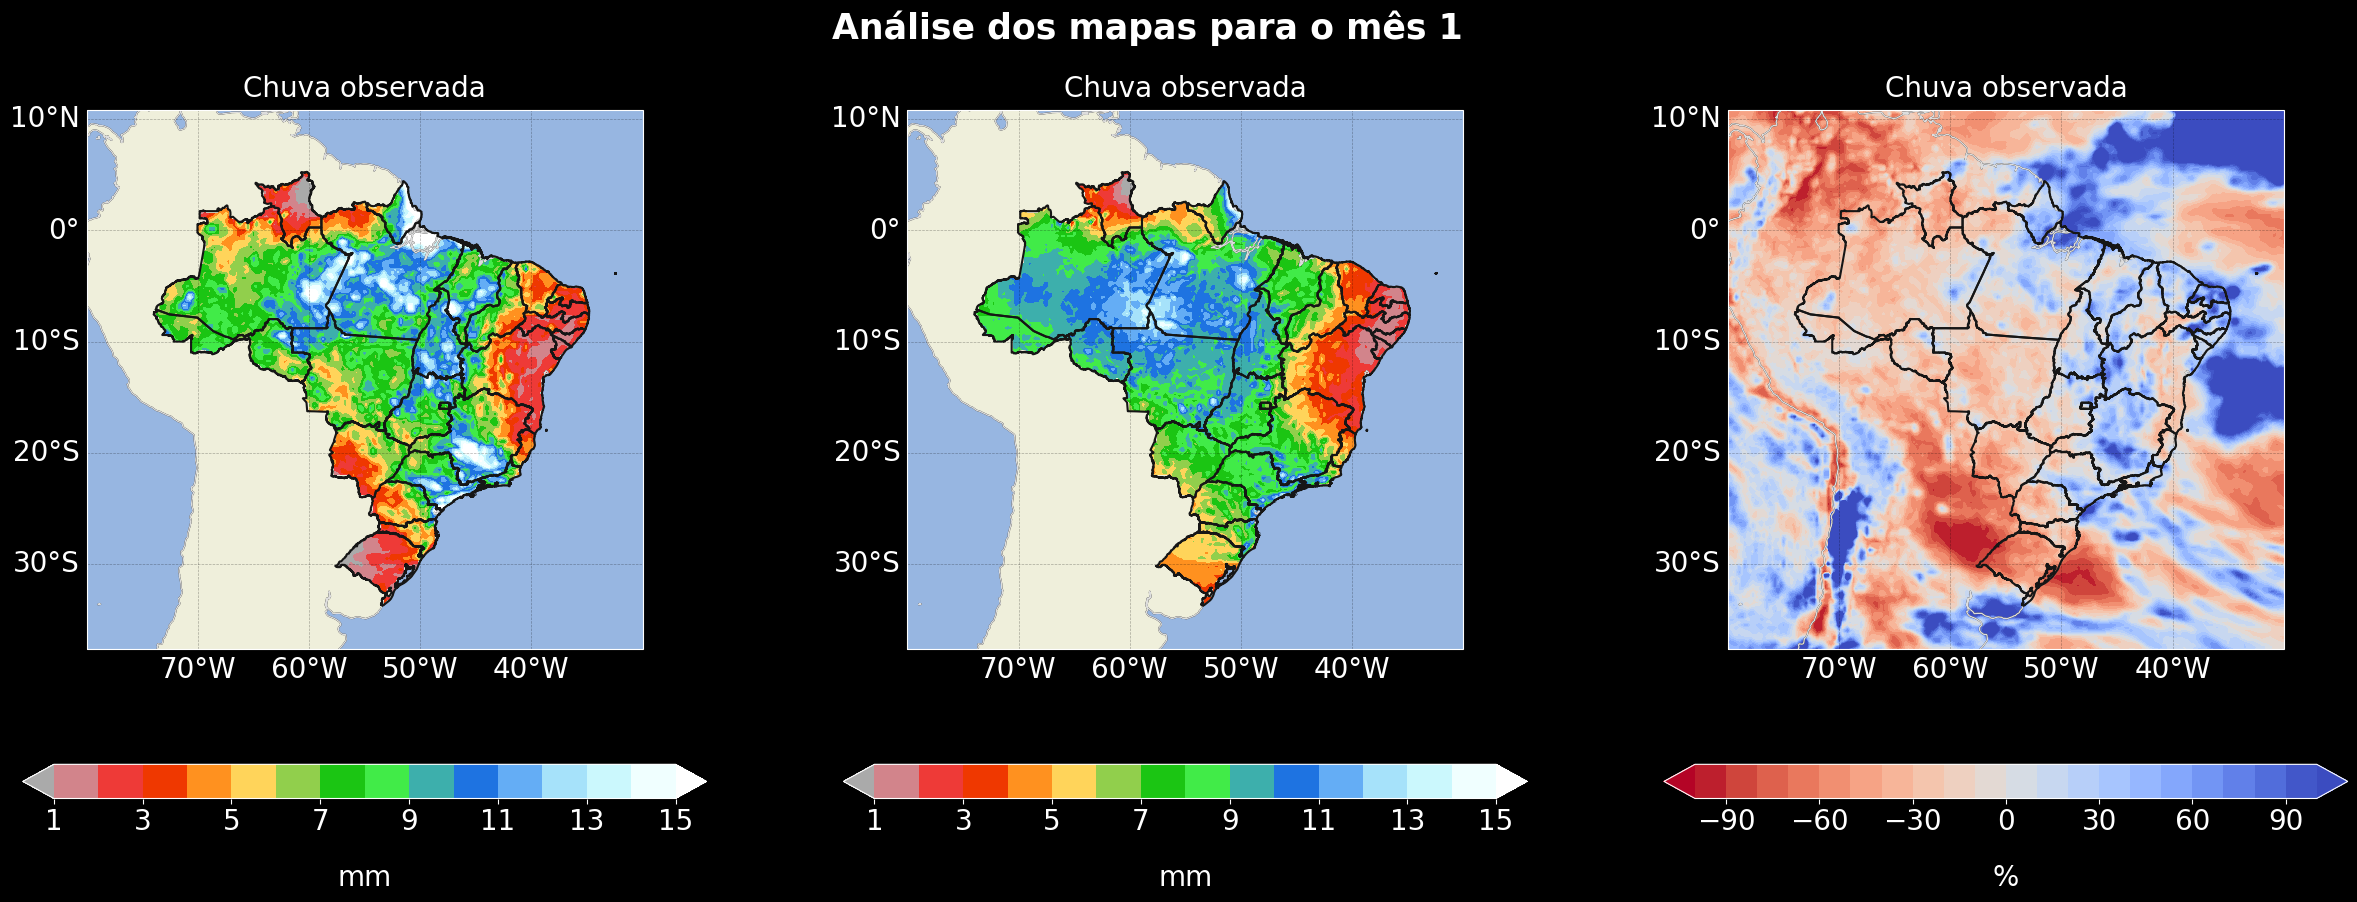

In [15]:
fig , (ax1, ax2, ax3) = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()),
                                     nrows = 1,
                                     ncols=3,
                                     figsize = (30,10)
                                     )   

month = 1

fig.suptitle(f'Análise dos mapas para o mês {month}', fontsize=25, weight="bold")

 # Ajusta figura para agrupar os diferentes plots
fig.subplots_adjust()

observed = ax1.contourf(ds_obs['longitude'].values,
                        ds_obs['latitude'].values,
                        ds_obs['tp'].sel(month=month),
                        levels = np.arange(1, 16, 1),
                        cmap = ons_cmap_r,
                        extend='both'
                        )

cbar_1 = plt.colorbar(mappable= observed,
                      orientation = 'horizontal',
                      ax=ax1
 )                        

cbar_1.ax.tick_params(labelsize=20)
cbar_1.set_label('mm', fontsize=20, labelpad=20)
ax1.set_title('Chuva observada', fontsize=20)


climatologia = ax2.contourf(ds_clim['longitude'].values,
                        ds_clim['latitude'].values,
                        ds_clim['tp'].sel(month=month),
                        levels = np.arange(1, 16, 1),
                        cmap = ons_cmap_r,
                        extend='both'
                        )

cbar_2 = plt.colorbar(mappable= climatologia,
                      orientation = 'horizontal',
                      ax=ax2
 )                        

cbar_2.ax.tick_params(labelsize=20)
cbar_2.set_label('mm', fontsize=20, labelpad=20)
ax2.set_title('Chuva observada', fontsize=20)


                        
anomalia = ax3.contourf(ds_anom['longitude'].values,
                        ds_anom['latitude'].values,
                        ds_anom['tp'].sel(month=month),
                        levels = np.arange(-100, 110, 10),
                        cmap = "coolwarm_r",
                        extend='both'
                        )

cbar_3 = plt.colorbar(mappable= anomalia,
                      orientation = 'horizontal',
                      ax=ax3
 )                        

cbar_3.ax.tick_params(labelsize=20)
cbar_3.set_label('%', fontsize=20, labelpad=20)
ax3.set_title('Chuva observada', fontsize=20)

for area_plotagem in [ax1, ax2, ax3]:
    geoaxes.GeoAxes(ax=area_plotagem).geosettings(
                                        extent=[-80, -30, 10, -35],
                                        shapefile=shapefile,
                                        ylocator=np.arange(-180, 180, 10))


